In [90]:
import csv
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

import os
from dotenv import load_dotenv
import time

In [91]:
# Fetch environment variables
load_dotenv()
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

# Set up Spotify API credentials
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [92]:
# ------------------------------ GET USER PLAYLIST DATA ------------------------------
features = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
user_playlist = pd.read_csv('../Playlists/hedgehog\'s_dilemma.csv')
# user_playlist = pd.read_csv('../Playlists/you_wanna_rock.csv')
user_tracks = [] # Output of list of track dicts
track_info_100 = [] # Intermediate list for storing track info
track_ids_100 = [] # Intermediate list for storing track ids
for index, row in user_playlist.iterrows():
    id = row['Track URI'][14:]
    track_ids_100.append(id)
    track_info = {
        '':index,
        'artist_name': row['Artist Name(s)'],
        'track_name': row['Track Name'],
        'track_id': id,
        # ... we will add more attributes later
    }
    track_info_100.append(track_info)

    if len(track_ids_100) == 100 or index == len(user_playlist) - 1:
        response = sp.audio_features(track_ids_100)
        print(f"Successful response with {len(response)} entries")
        # Update track info for each song
        for response_index, audio_features in enumerate(response):
            if audio_features:  # Check if audio_features is not None
                for feature in features:
                    track_info_100[response_index][feature] = audio_features[feature]
                user_tracks.append(track_info_100[response_index])
        # Reset intermediate variables
        print(f"Total songs stored so far: {len(user_tracks) = }")
        track_ids_100 = []
        track_info_100 = []
        time.sleep(2)
user_df = pd.DataFrame(user_tracks)
print(user_df) # The printed index should be the length of user playlist minus one

Successful response with 70 entries
Total songs stored so far: len(user_tracks) = 70
               artist_name                                track_name  \
0    0          grentperez                  (Only) About Love - Demo   
1    1               LeeHi                                      ONLY   
2    2        IV Of Spades                   Come Inside Of My Heart   
3    3  Seycara Orchestral  I Wish You Would Come Closer and Hold Me   
4    4  Seycara Orchestral                                     Luv U   
..  ..                 ...                                       ...   
65  65  The Rare Occasions                       Because You Love Me   
66  66       Teddy Adhitya                                  Just You   
67  67              Mitski                     My Love Mine All Mine   
68  68              kuiper                                   options   
69  69       Jeremy Zucker                                  comethru   

                  track_id  danceability  energy  

In [93]:
# Exclude track name, artist name, track id, index,...
user_features = user_df[features] 
# Get centroid vector of user playlist
centroid_vec = user_features.mean(axis=0)
user_centroid = pd.DataFrame(centroid_vec).transpose()
print(user_centroid)

   danceability    energy  key  loudness  mode  speechiness  acousticness  \
0      0.621729  0.450871  5.3 -9.477371   0.8     0.058121      0.521072   

   instrumentalness  liveness   valence       tempo    duration_ms  \
0          0.083521  0.150039  0.466384  115.205857  189014.228571   

   time_signature  
0        3.871429  


In [94]:
# ------------------------------ GET CENTROIDS OF 1K PLAYLIST DATASET ------------------------------
slices = ["0-999", "1000-1999", "2000-2999", "3000-3999", "4000-4999", "5000-5999", "6000-6999", "7000-7999", "8000-8999", "9000-9999"]
# ---------- YOUR FILEPATHS HERE ----------
FILENAME = "mpd.slice.0-999.json"
FOLDER = r"../spotify_million_playlist_dataset/data"
PATH = FOLDER + "/" + FILENAME
# ---------- YOUR FILEPATHS HERE ----------
dataset_tracks = pd.read_csv('../mpd.slice.0-999.csv')
playlists = []
with open(PATH, "r") as playlist_file:
    batch = json.load(playlist_file)
    print(f"Loading complete! Beginning parsing...")
    # Loop through all playlists
    for playlist_index, playlist in enumerate(batch["playlists"]):
        print(f"\nScanned playlist {playlist_index} ({len(playlist['tracks'])} songs)")
        playlist_tracks = []
        # Loop through tracks in playlist
        for track_index, track in enumerate(playlist["tracks"]):
            id = track["track_uri"][14:]
            # Search for playlist track in dataset
            matches = dataset_tracks[dataset_tracks['track_id'] == id]
            if matches.empty:
                continue
            # Get one of the matches as a DataFrame (all should be the same data, just different indices)
            match = matches.iloc[[0]]
            track_features = match.to_dict('records')[0] # Convert DataFrame to Dictionary
            playlist_tracks.append(track_features)

        if len(playlist_tracks) > 0: # Non-empty number of tracks in playlist
            playlists.append(pd.DataFrame(playlist_tracks))

print(f"Considering {len(playlists)} out of 1000 playlists in json.")

Loading complete! Beginning parsing...

Scanned playlist 0 (52 songs)

Scanned playlist 1 (39 songs)

Scanned playlist 2 (64 songs)

Scanned playlist 3 (126 songs)

Scanned playlist 4 (17 songs)

Scanned playlist 5 (80 songs)

Scanned playlist 6 (16 songs)

Scanned playlist 7 (53 songs)

Scanned playlist 8 (46 songs)

Scanned playlist 9 (21 songs)

Scanned playlist 10 (72 songs)

Scanned playlist 11 (134 songs)

Scanned playlist 12 (9 songs)

Scanned playlist 13 (13 songs)

Scanned playlist 14 (103 songs)

Scanned playlist 15 (7 songs)

Scanned playlist 16 (105 songs)

Scanned playlist 17 (79 songs)

Scanned playlist 18 (68 songs)

Scanned playlist 19 (85 songs)

Scanned playlist 20 (14 songs)

Scanned playlist 21 (15 songs)

Scanned playlist 22 (42 songs)

Scanned playlist 23 (20 songs)

Scanned playlist 24 (7 songs)

Scanned playlist 25 (41 songs)

Scanned playlist 26 (26 songs)

Scanned playlist 27 (12 songs)

Scanned playlist 28 (81 songs)

Scanned playlist 29 (40 songs)

Scanned p

In [160]:
# playlists is a list holding each playlist
# each playlist is a dataframe holding dataframes of tracks
print(len(playlists))
for playlist in playlists:
    #print(playlist)
    print(playlist.columns)
    break
    print("playlist type", type(playlist))
    for track in playlist:
        print("track type", type(track))
        print(track)

1000
Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')


In [95]:
# ------------------------------ CALCULATE PLAYLIST CENTROIDS ------------------------------
features = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
centroids = []
for index, playlist in enumerate(playlists):
    # Exclude track name, artist name, track id, index,...
    pl_features = playlist[features] 
    # Get centroid vector of user playlist
    centroid_vec = pl_features.mean(axis=0)
    pl_centroid = pd.DataFrame(centroid_vec).transpose()
    centroids.append(pl_centroid)
    # print(pl_centroid)

# Convert centroids to a DataFrame for clustering
centroids_df = pd.concat(centroids, ignore_index=True) # Stack dataframes on top of each other as rows
print(centroids_df)
# found = centroids_df.iloc[0] # Get first row centroid

     danceability    energy       key   loudness      mode  speechiness  \
0        0.663577  0.781038  5.038462  -4.891269  0.692308     0.103925   
1        0.492382  0.695923  4.461538  -8.107974  0.538462     0.091003   
2        0.671062  0.692953  5.000000  -4.875594  0.515625     0.096425   
3        0.514429  0.620917  5.103175  -9.618754  0.714286     0.066999   
4        0.575647  0.653006  3.352941  -7.509529  0.823529     0.040971   
..            ...       ...       ...        ...       ...          ...   
995      0.597244  0.655049  6.000000  -8.745341  0.804878     0.046712   
996      0.661235  0.487700  5.352941  -8.565294  0.588235     0.179206   
997      0.735412  0.690546  5.067227  -5.989563  0.630252     0.183550   
998      0.558444  0.660083  5.166667  -5.622741  0.935185     0.036334   
999      0.541818  0.334182  5.090909 -11.205568  0.818182     0.067975   

     acousticness  instrumentalness  liveness   valence       tempo  \
0        0.083636          0

In [189]:
# ------------------------------ CLUSTER PLAYLISTS ------------------------------
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

# Drop the 'cluster' column from centroids_df to exclude it from the input
if 'cluster' in centroids_df.columns:
    centroids_df = centroids_df.drop(columns=['cluster'])

# Perform k-means clustering on the playlist centroids
k = 10
kmeans = KMeans(n_clusters=k)
kmeans.fit(centroids_df)

KMeans(n_clusters=10)

In [190]:
print("\nClustered Playlist Centroids:")
print(centroids_df.head(5))


Clustered Playlist Centroids:
   danceability    energy       key  loudness      mode  speechiness  \
0      0.663577  0.781038  5.038462 -4.891269  0.692308     0.103925   
1      0.492382  0.695923  4.461538 -8.107974  0.538462     0.091003   
2      0.671062  0.692953  5.000000 -4.875594  0.515625     0.096425   
3      0.514429  0.620917  5.103175 -9.618754  0.714286     0.066999   
4      0.575647  0.653006  3.352941 -7.509529  0.823529     0.040971   

   acousticness  instrumentalness  liveness   valence       tempo  \
0      0.083636          0.000674  0.187087  0.642500  121.155519   
1      0.162238          0.223708  0.179344  0.476641  124.987103   
2      0.269100          0.000638  0.168894  0.565078  114.595984   
3      0.273513          0.203156  0.188279  0.451274  125.547548   
4      0.176759          0.081759  0.166818  0.486118  127.727118   

     duration_ms  time_signature  
0  221777.461538        4.000000  
1  298837.641026        3.769231  
2  219373.953125

In [127]:
# ------------------------------ ASSIGN USER PLAYLIST ------------------------------
user_cluster = kmeans.predict(user_centroid)
print(f"Predicted cluster: {user_cluster}")

Predicted cluster: [2]


In [130]:
# Add cluster labels to the centroids DataFrame
centroids_df['cluster'] = kmeans.labels_

print("\nClustered Playlist Centroids:")
print(centroids_df.head(5))


Clustered Playlist Centroids:
   danceability    energy       key  loudness      mode  speechiness  \
0      0.663577  0.781038  5.038462 -4.891269  0.692308     0.103925   
1      0.492382  0.695923  4.461538 -8.107974  0.538462     0.091003   
2      0.671062  0.692953  5.000000 -4.875594  0.515625     0.096425   
3      0.514429  0.620917  5.103175 -9.618754  0.714286     0.066999   
4      0.575647  0.653006  3.352941 -7.509529  0.823529     0.040971   

   acousticness  instrumentalness  liveness   valence       tempo  \
0      0.083636          0.000674  0.187087  0.642500  121.155519   
1      0.162238          0.223708  0.179344  0.476641  124.987103   
2      0.269100          0.000638  0.168894  0.565078  114.595984   
3      0.273513          0.203156  0.188279  0.451274  125.547548   
4      0.176759          0.081759  0.166818  0.486118  127.727118   

     duration_ms  time_signature  cluster  
0  221777.461538        4.000000        5  
1  298837.641026        3.769231 

In [184]:
# ------------------------------ GET USER CLUSTER ------------------------------
# Find rows in centroids_df that have the same cluster as the user
factors = ['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

relevant = centroids_df[centroids_df['cluster'] == float(user_cluster[0])] # DataFrame of rows with centroids and cluster
# Get indices of rows
indices = relevant.index
# Loop through relevant playlists
relevant_playlists = []
for pl_index in indices:
    relevant_playlists.append(playlists[pl_index]) # Append DataFrame playlist
relevant_tracks = pd.concat(relevant_playlists, ignore_index=True)
print(len(relevant_tracks))
# Remove Duplicates by: Subtracting user_df from relevant_tracks based on 'id'
relevant_tracks = pd.merge(relevant_tracks, user_df, on='track_id',how='left',suffixes=('','_a'), indicator=True).query('_merge == "left_only"')
relevant_tracks = relevant_tracks[factors] # Remove duplicate columns
relevant_features = relevant_tracks[features] # Remove track_name, artist_name, id, ...

2215


In [186]:
distances = euclidean_distances(user_centroid, relevant_features).flatten()
# Add distances to relevant_tracks DataFrame
relevant_tracks['distance'] = distances

# Sort by Euclidean distance and select top n_recs
n_recs = 5
recommendations = relevant_tracks.sort_values(by=['distance'], ascending=[True]).drop_duplicates(subset=['track_id']).head(n_recs)

# We should always be able to find enough recs unless it's an absurdly large amount

print("Here are some songs I recommend adding to your playlist!")
print(recommendations)

Here are some songs I recommend adding to your playlist!
      Unnamed: 0     artist_name                                 track_name  \
264        15763  Tegan and Sara                         This Is Everything   
1016        7369       The Clash  Should I Stay or Should I Go - Remastered   
1524       28018   Vince Staples                                 Yeah Right   
465        17500    Voz De Mando                          Muchacho De Campo   
2190       16916  Hannah Montana                                True Friend   

                    track_id  danceability  energy  key  loudness  mode  \
264   4vMnMeIoKj85UR5PkE1YyX         0.747   0.342   11   -11.337     1   
1016  39shmbIHICJ2Wxnk1fPSdz         0.743   0.836    2    -6.465     1   
1524  35tWhD29yvWwB0IDRr6zsL         0.734   0.468    1    -9.029     1   
465   3qK0HkXzkrLvwU2P6MhLpN         0.811   0.381    8    -9.889     1   
2190  322E3pHVE4THhniKjNLTY9         0.657   0.778    4    -5.004     1   

      speechiness

In [187]:
# What was our user playlist centroid?
print(user_centroid)

   danceability    energy  key  loudness  mode  speechiness  acousticness  \
0      0.621729  0.450871  5.3 -9.477371   0.8     0.058121      0.521072   

   instrumentalness  liveness   valence       tempo    duration_ms  \
0          0.083521  0.150039  0.466384  115.205857  189014.228571   

   time_signature  
0        3.871429  


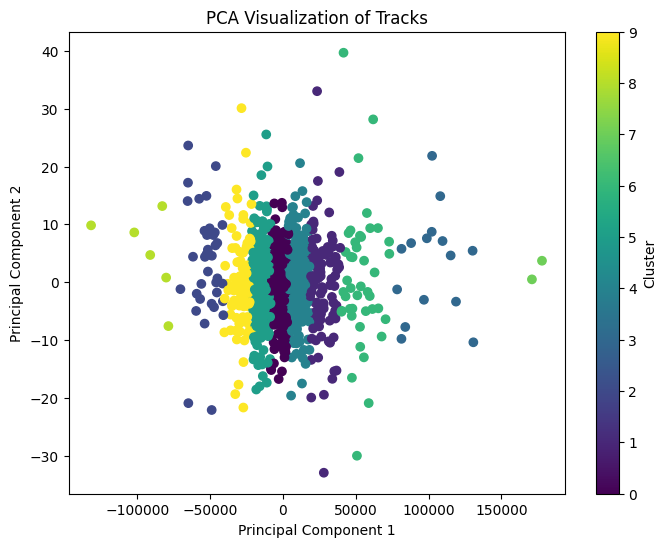

In [188]:
# Graphing stuff?
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(centroids_df)

Df = pd.DataFrame(data=principalComponents,
                           columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([Df, centroids_df[['cluster']]], axis=1)

plt.figure(figsize=(8,6))
plt.scatter(Df['principal component 1'], Df['principal component 2'], c=centroids_df['cluster'].values, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.title('PCA Visualization of Tracks')

plt.show()

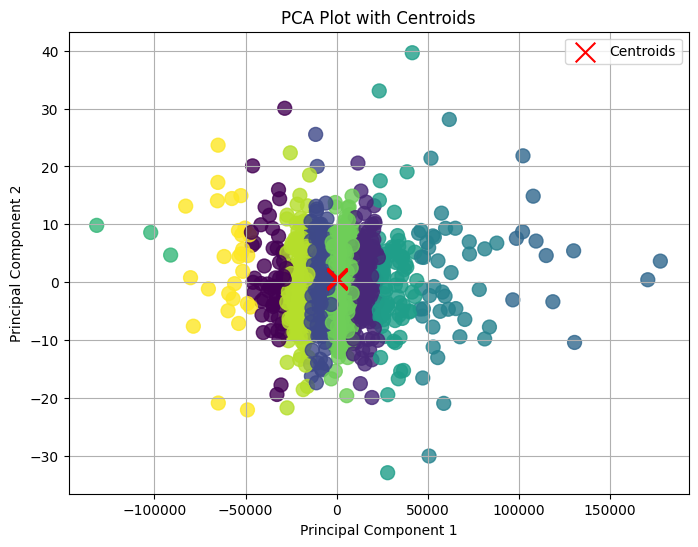

In [ ]:
# Perform PCA on the centroids
pca = PCA(n_components=2)
centroids_pca = pca.fit_transform(centroids_df)

# Plot PCA-transformed data points
plt.figure(figsize=(8, 6))
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=100, alpha=0.8)

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')

plt.title('PCA Plot with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()